# Quadcopter Activity Recognition 

Welcome to this training module that teaches you how to perform activity recognition with the help of a hosted Machine Learning instance. This notebook will guide you through the process of extracting information from your flight record!

## Step 1) Getting started

Let's start by importing libraries we will use and defining constants we will be using during the course of this training module.

In [1]:
print('===[STEP 1 - START]===\n')
print('Setting up activity runtime environment...')

print('Importing used libraries...')
import json
import boto3
import boto3.session
import string
import os
import csv

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from csv import reader
from IPython.core.display import display, HTML

print('Defining runtime constants...')
s3_workspace_bucket = 'mldelarosa-thesis'
s3_subdir_group_classification_flight_log = 'mar-lab-workspace/exercise-classifying/group-classification-dataset/'
s3_subdir_group_classification_dataset = 'mar-lab-workspace/exercise-classifying/group-classification-dataset/'
jupyter_subdir_group_classification_dataset = './data/group-dataset/'
jupyter_subdir_group_classification_flight_log = './data/group-logs/'
jupyter_subdir_group_workspace = './data/group-workspace/'

print('Defining custom functions...')
def make_directory(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

def get_s3_client():
    session = boto3.session.Session()
    s3 = session.resource(service_name='s3', verify=True)
    return s3.meta.client

def print_file_preview(file, lines, hasHeader):
    stringFormat = ''
    print('\n\n===== FILE PREVIEW: ' + file + ' =====')
    if hasHeader:
        with open(file) as fileToPreview:
            fileIter = [next(fileToPreview) for x in range(lines)]
            for x in range(lines):
                lineCSV = fileIter[x].rstrip().split(',')
                if x == 0:
                    numOfColumns = len(lineCSV)
                    dash = '-' * (18 * numOfColumns)
                    stringFormat = '{:16.16}| ' * numOfColumns
                    print(dash)
                    print(stringFormat.format(*lineCSV))
                    print(dash)
                else:
                    print(stringFormat.format(*lineCSV))
                    
    else:
        with open(file) as fileToPreview:
            fileIter = [next(fileToPreview) for x in range(lines)]
            for x in range(lines):
                lineCSV = fileIter[x].rstrip().split(',')
                if x == 0:
                    numOfColumns = len(lineCSV)
                    stringFormat = '{:16.16}| ' * numOfColumns
                print(stringFormat.format(*lineCSV)[0:125])
    
    print('...')
    print('===== END FILE PREVIEW =====\n\n')

def print_file_link(prepend, filepath, name):
    display(HTML(prepend + '<a target="_blank" href="' + filepath + '">' + name + '</a>'))


print('[DONE] Runtime initialized')
print('\n===[STEP 1 - END]===')

===[STEP 1 - START]===

Setting up activity runtime environment...
Importing used libraries...
Defining runtime constants...
Defining custom functions...
[DONE] Runtime initialized

===[STEP 1 - END]===


## Step 2) Flight Log

During your flight session, the quadrotor logged a flight status of your session. This flight log contains human readable descriptions of internal processes running over the course of the session. This includes successful startup and initialization of on-board devices as well as notes of startup sequences and errors encountered during the flight.

In [2]:
print('===[STEP 2 - DOWNLOADING FLIGHT LOG - START]===\n')

GROUP_NAME = 'default'
print('Please enter the name of your lab group...')
GROUP_NAME = (input('Group Name: ') or "held-with-manual-control")
print('Please enter the specific flight session, or skip to choose the latest log...')
flightSession = (input('Flight Session: ') or "latest")
print ('Pulling flight data from S3 for group [',GROUP_NAME,'] on session [', flightSession, '] ...')

client = get_s3_client();
if (flightSession == "latest"):
    s3_filepath_group_classification_flight_log_latest = s3_subdir_group_classification_flight_log + GROUP_NAME + '/flight-log-latest';
    jupyter_filepath_group_classification_flight_log_latest = jupyter_subdir_group_workspace + GROUP_NAME + '/flight-log-latest.txt';
else:
    s3_filepath_group_classification_flight_log_latest = s3_subdir_group_classification_flight_log + GROUP_NAME + '/flight-log-' + flightSession + '.txt';
    jupyter_filepath_group_classification_flight_log_latest = jupyter_subdir_group_workspace + GROUP_NAME + '/flight-log-latest.txt';

print('Downloading from: ' + s3_workspace_bucket + '/' + s3_filepath_group_classification_flight_log_latest);
make_directory(jupyter_filepath_group_classification_flight_log_latest);
print('Downloading to: ' + jupyter_filepath_group_classification_flight_log_latest);

group_flight_record = client.download_file(Bucket=s3_workspace_bucket,
                                           Key=s3_filepath_group_classification_flight_log_latest,
                                           Filename=jupyter_filepath_group_classification_flight_log_latest)
print_file_link('Finished download flight log to ', jupyter_filepath_group_classification_flight_log_latest, 'flight-log-latest.txt')
print('========= ' + GROUP_NAME + '\'s FLIGHT LOG =========')
with open(jupyter_filepath_group_classification_flight_log_latest, 'r') as flightLog:
    print(flightLog.read())
    
print('\n===[STEP 2 - END]===\n')

===[STEP 2 - DOWNLOADING FLIGHT LOG - START]===

Please enter the name of your lab group...
Group Name: held-with-manual-control
Please enter the specific flight session, or skip to choose the latest log...
Flight Session: ududrlfb
Pulling flight data from S3 for group [ held-with-manual-control ] on session [ ududrlfb ] ...


========= held-with-manual-control's FLIGHT LOG =========
[ENABLED] CLASSIFICATION MODE for UNLABELLED raw IMU CSV data log...
Setting Battery Gain 1 [0.985]
Setting Roll Acc_Trim [1.73728]
Setting Roll Acc_Trim [1.73728]
Setting Roll Trim  [0.81]
Setting Roll Trim  [-1]
Setting Roll Trim  [-35.5]
Setting Take-off Trim Rotor 1 [110]
Setting Take-off Trim Rotor 2 [0]
Setting Take-off Trim Rotor 3 [70]
Setting Take-off Trim Rotor 4 [0]
Setting Flight Trim Rotor 1 [0]
Setting Flight Trim Rotor 2 [0]
Setting Flight Trim Rotor 3 [0]
Setting Flight Trim Rotor 4 [0]
Initializing PID Flight Controller...
Initializing Analog and GPIO pins...
Initializing I2C Devices...
[DONE] Initialized I2C in Fast mode....
Initializing I2C Slave Device....
Constructing Gyro...
Initializing Gyro I2C Device....
Initializing Distance Sensor....
[DONE] Initialized Gyro I2C Device....
Constructing ESC Controller...
Initializing ESC Controller I2C Device....
[DONE] Initialized ESC Controller I2C Device....
Initiali

## Step 3) Flight Data
Let's pull up your latest flight data from S3 that was uploaded from the quadrotor. The lab quadrotor has recorded IMU data during your flight session and recorded the data onto a .csv file.

In [3]:
print('===[STEP 3 - DOWNLOADING FLIGHT DATA - START]===\n')
print ('Pulling latest flight log data from S3 for group [' + GROUP_NAME + ']');

client = get_s3_client()

if (flightSession == "latest"):
    s3_filepath_group_classification_dataset_latest = s3_subdir_group_classification_dataset + GROUP_NAME + '/imu-data-log-latest';
    jupyter_filepath_group_classification_dataset_latest = jupyter_subdir_group_classification_dataset + GROUP_NAME + '/imu-latest-dataset.csv';
else:
    s3_filepath_group_classification_dataset_latest = s3_subdir_group_classification_dataset + GROUP_NAME + '/imu-data-log-' + flightSession + '.csv';
    jupyter_filepath_group_classification_dataset_latest = jupyter_subdir_group_classification_dataset + GROUP_NAME + '/imu-latest-dataset.csv';


print('Downloading from: ' + s3_workspace_bucket + '/' + s3_filepath_group_classification_dataset_latest)

make_directory(jupyter_filepath_group_classification_dataset_latest)
print('Downloading to: ' + jupyter_filepath_group_classification_dataset_latest)
group_flight_record = client.download_file(Bucket=s3_workspace_bucket,
                                           Key=s3_filepath_group_classification_dataset_latest,
                                           Filename=jupyter_filepath_group_classification_dataset_latest)

print_file_link('Finished downloading flight data to ', jupyter_filepath_group_classification_dataset_latest, 'imu-latest-dataset.csv')
print('[DONE]')
print_file_preview(jupyter_filepath_group_classification_dataset_latest, 10, 1)
print('\n===[STEP 3 - END]===')

===[STEP 3 - DOWNLOADING FLIGHT DATA - START]===

Pulling latest flight log data from S3 for group [held-with-manual-control]


[DONE]


===== FILE PREVIEW: ./data/group-dataset/held-with-manual-control/imu-latest-dataset.csv =====
------------------------------------------------------------------------------------------------------------
accelerometer_x | accelerometer_y | accelerometer_z | gyrometer_x     | gyrometer_y     | gyrometer_z     | 
------------------------------------------------------------------------------------------------------------
0.00512695      | 0.00244141      | -1.0564         | 0.278736        | 0.454388        | -0.114275       | 
0.00317383      | 0.00292969      | -1.04126        | -0.0266076      | 0.316983        | -0.793664       | 
0.00170898      | 0.00415039      | -1.03931        | -0.0342412      | 0.301716        | -0.824199       | 
-0.000488281    | 0.00854492      | -1.03662        | -0.179279       | 0.347518        | -0.908168       | 
-0.000488281    | 0.0109863       | -1.03931        | -0.431188       | 0.248281        | -0.87           | 
-0.00292969     | 0.0090

## Step 4) Flight data visualization

Now that you've downloaded the flight log and flight data, run the cell below to plot a visual representation of the flight data retrieved from Step 3.

===[STEP 4] - VISUALIZING FLIGHT DATA - START]===



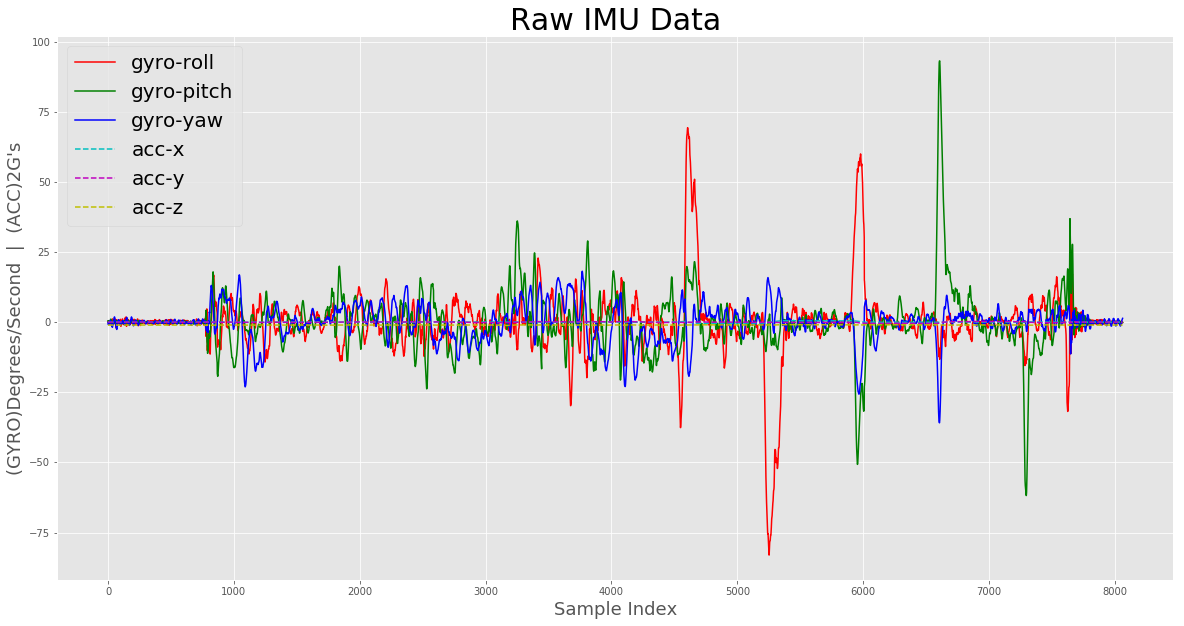

===[STEP 4] - END]===



In [4]:
print('===[STEP 4] - VISUALIZING FLIGHT DATA - START]===\n')

# split flight data into windows of data samples for each label
matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['toolbar'] = 'toolbar2'

def graph_raw_flight_record_data(data_filepath):
    with open(data_filepath) as raw_flight_record:
        raw_imu_data = list(reader(raw_flight_record))
        global FLIGHT_RECORD_LENGTH
        FLIGHT_RECORD_LENGTH = len(raw_imu_data)
    plt.style.use('ggplot')
    acc_x = [float(i[0]) for i in raw_imu_data[1::]]
    acc_y = [float(i[1]) for i in raw_imu_data[1::]]
    acc_z = [float(i[2]) for i in raw_imu_data[1::]]
    gyro_roll = [float(i[3]) for i in raw_imu_data[1::]]
    gyro_pitch = [float(i[4]) for i in raw_imu_data[1::]]
    gyro_yaw = [float(i[5]) for i in raw_imu_data[1::]]
    x_t_index = np.arange(len(gyro_roll))
    plt.plot(x_t_index, gyro_roll, 'r', gyro_pitch, 'g', gyro_yaw, 'b', acc_x, 'c--', acc_y, 'm--', acc_z, 'y--')
    plt.legend(['gyro-roll', 'gyro-pitch', 'gyro-yaw', 'acc-x', 'acc-y', 'acc-z'], fontsize=20)
    plt.title('Raw IMU Data', fontsize=30)
    plt.xlabel('Sample Index', fontsize=18)
    plt.ylabel('(GYRO)Degrees/Second  |  (ACC)2G\'s', fontsize=18)
    plt.show()
    
graph_raw_flight_record_data(jupyter_filepath_group_classification_dataset_latest)
print('===[STEP 4] - END]===\n')

# Prepping IMU data for classification

The IMU data needs to be converted into a format that is compatible with the classifier. This is done by performing a sliding window iteration, collecting windows of sample data, and calculating features from those windows of data

## Step 5) Define feature functions
Set of functions are defined which will be used to calculate the feature of a given data sample

In [5]:
print('===[STEP 5] - DEFINING FEATURE FUNCTIONS - START ===\n')

print('Defining AVERAGE feature function')
def feature_average(data_sample):
    fSum = 0;
    nIndex = 0;
    for data in data_sample:
        fSum = fSum + data
        nIndex = nIndex + 1
    return float(fSum / nIndex)

# Not in use
#print('Defining VARIANCE feature function')
#def feature_variance(data_sample):
#    return np.var(data_sample)

print('Defining MEDIAN feature function')
def feature_median(data_sample):
    return np.median(data_sample, axis=0)

feature_calculations = {
    'average' : feature_average,
    'median' : feature_median
}

print('Finished feature definitions')
print('\n===[STEP 5 - DONE]===\n')

===[STEP 5] - DEFINING FEATURE FUNCTIONS - START ===

Defining AVERAGE feature function
Defining MEDIAN feature function
Finished feature definitions

===[STEP 5 - DONE]===



## Step 6) Extracting features from sliding windows
All .csv files are iterated through line-by-line and window of data sample is extracted from the 

In [6]:
print('===[STEP 6] - EXTRACTING FEATURES FROM SAMPLES OF SLIDING WINDOWS - START ===\n')

import csv
from itertools import islice
import numpy as np

FEATURE_DATA_FILEPATH = './data/'
feature_csv_columns = ['average', 'median']
imu_data_columns = ['accelerometer_x','accelerometer_y','accelerometer_z','gyrometer_x','gyrometer_y','gyrometer_z']

# Read a *.csv file and extract the sliding window
import collections
def extract_features_from_imu_data(data_sample_filepath, features_filepath):
    print('Extracting features from file [' + data_sample_filepath + '] into the directory [' + features_filepath + ']')
    
    # Open the file to extract features from
    with open(data_sample_filepath, 'r') as csv_file:
        with open(features_filepath, 'a') as features_file:
            # read csv file by row
            reader = csv.DictReader(csv_file)
           # sliding_windows = []
            sliding_index = 0
            window_step_forward = 1
            window_length = 4

            # extract sliding windows from rows
            print('Extracting sliding window data samples from [' + data_sample_filepath + ']...')
            sliding_window_csv = []
            rowCount = 0;
            for row in reader:
                rowCount = rowCount + 1;
                sliding_window_csv.append(row)
                if(len(sliding_window_csv) == window_length + 1):
                    del sliding_window_csv[0]
                if(sliding_index % window_step_forward == 0 and len(sliding_window_csv) == window_length):
                    running_window_line = ''
                    for feature_name in feature_csv_columns:
                        window_sequence = []
                        for imu_data_column in imu_data_columns:
                            window_sequence = []
                            for sliding_window in list(sliding_window_csv):
                                window_sequence.append(round(float(sliding_window[imu_data_column]), 6))

                            window_index = 0
                            window_count = len(window_sequence)
                            feature_func = feature_calculations[feature_name]
                            running_window_line += (str(feature_func(window_sequence))) + ','
                            window_index = window_index + 1
                    features_file.write(running_window_line[:-1] + '\n')
                sliding_index = sliding_index + 1

# Create and store extracted features from imu data
imu_feature_extraction = './data/group-workspace/' + GROUP_NAME + '/imu-and-features-dataset-latest.csv';
make_directory(imu_feature_extraction)
with open(imu_feature_extraction, 'w') as file:
    file.write('')
    print('Clearing file...')

# start the feature extraction process
extract_features_from_imu_data(jupyter_filepath_group_classification_dataset_latest, imu_feature_extraction)
print_file_link('Finished extracting features to ', imu_feature_extraction, 'imu-and-features-dataset-latest.csv')
print('DONE')
print_file_preview(imu_feature_extraction, 10, 0)

print('===[STEP 6 - DONE] ===\n')

===[STEP 6] - EXTRACTING FEATURES FROM SAMPLES OF SLIDING WINDOWS - START ===

Clearing file...
Extracting features from file [./data/group-dataset/held-with-manual-control/imu-latest-dataset.csv] into the directory [./data/group-workspace/held-with-manual-control/imu-and-features-dataset-latest.csv]
Extracting sliding window data samples from [./data/group-dataset/held-with-manual-control/imu-latest-dataset.csv]...


DONE


===== FILE PREVIEW: ./data/group-workspace/held-with-manual-control/imu-and-features-dataset-latest.csv =====
0.0023805       | 0.0045165       | -1.0433975000000| 0.00965199999999| 0.35515125000000| -0.6600765      | 0.0024415       |
0.00097675000000| 0.00665275      | -1.0391249999999| -0.167829       | 0.3036245       | -0.8490077500000| 0.0006105       |
-0.0005492499999| 0.0081785       | -1.039735       | -0.3052335000000| 0.2501895       | -0.8528245      | -0.000488       |
-0.00219725     | 0.00915525      | -1.0405875      | -0.4540885      | 0.14331924999999| -0.8299234999999| -0.001709       |
-0.00457775     | 0.00848374999999| -1.042725       | -0.5590505      | -0.0036274999999| -0.7707632499999| -0.0039065      |
-0.0070192499999| 0.00695800000000| -1.0432725      | -0.5685925000000| -0.1333985      | -0.7383204999999| -0.0074465      |
-0.00903325     | 0.00640874999999| -1.0423575      | -0.51706575     | -0.21355125     | -0.7154197500000| -0.0101319999999|
-

## Step 6a - optional) Extract a random sample
Here, we take a random sample from the flight data, and extract its features through the sliding window method mentioned in the step above

Let's start at some index within your sample, let's say at index 3623


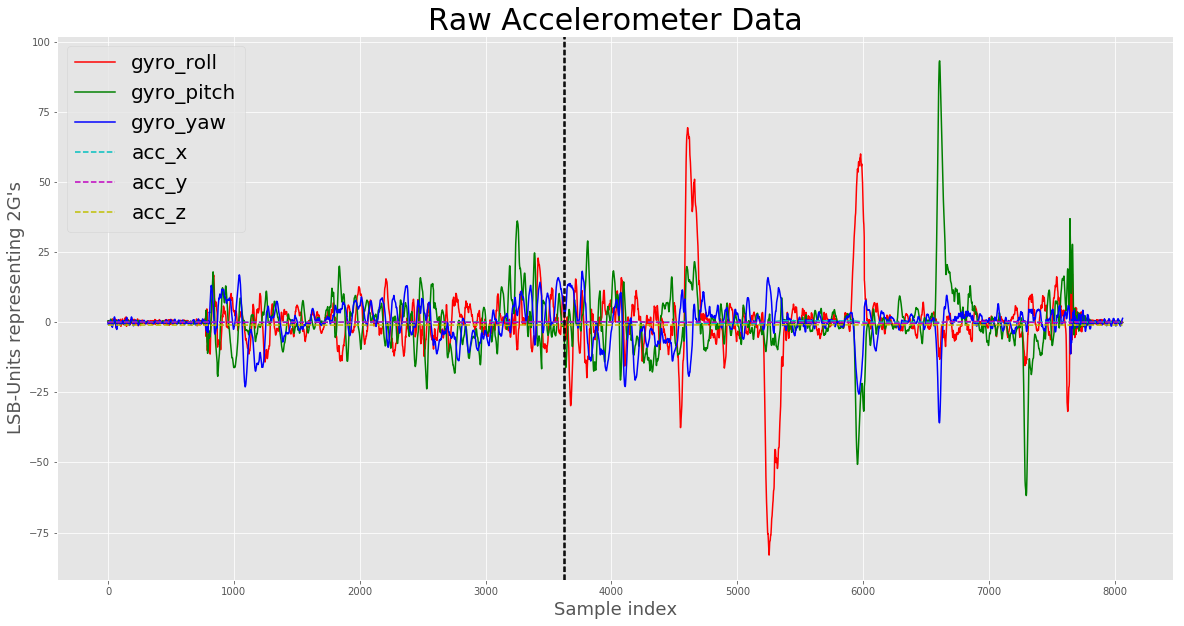

Here are the samples from that window of data:


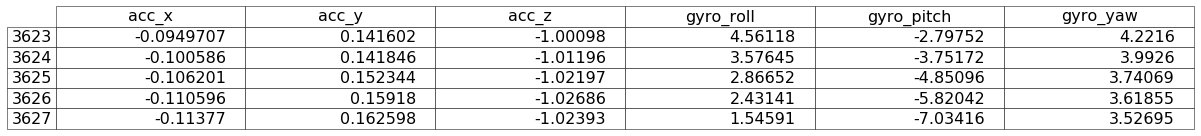

In [7]:
import random

flightRecordLength = FLIGHT_RECORD_LENGTH
WINDOW_LENGTH = 4

def graph_random_sample_for_group_data(flightRecordLength, filename):
    if(flightRecordLength < 10+2*WINDOW_LENGTH):
        print('Flight record too short to extract features [' + str(flightRecordLength) + ']')
    else:
        global randomSampleIndex
        randomSampleIndex = random.randint(1, flightRecordLength - 2 - WINDOW_LENGTH)
        print('Let\'s start at some index within your sample, let\'s say at index', randomSampleIndex)

        with open(filename, 'r') as csv_file:
            # extract data records by row
            reader = csv.DictReader(csv_file)
            sliding_windows = []
            sliding_index = 0
            window_step_forward = 1
            window_length = 4

            # extract sliding windows from rows
            sliding_window_csv = []
            sampleIndex = 0;
            for row in reader:
                sampleIndex = sampleIndex + 1

                if(sampleIndex < randomSampleIndex and sampleIndex < randomSampleIndex + WINDOW_LENGTH + 1):
                    sliding_window_csv.append(row)
                if(len(sliding_window_csv) == window_length + 1):
                    del sliding_window_csv[0]
                if(sliding_index % window_step_forward == 0 and len(sliding_window_csv) == window_length):
                    sliding_windows.append(list(sliding_window_csv))
                sliding_index = sliding_index + 1
            running_window_lines = []

            for feature_name in feature_csv_columns:
                for imu_data_column in imu_data_columns:
                    window_sequences = []
                    for sliding_window in sliding_windows:
                        window_sequence = []
                        for window in sliding_window:
                            window_sequence.append(float(window[imu_data_column]))
                        window_sequences.append(window_sequence)
#                     print(imu_data_column, ' - ', window_sequences)

                    window_index = 0
                    comma_index = 0;
                    window_count = len(window_sequences)
                    while len(running_window_lines) < window_count:
                        running_window_lines.append('')
                    for window in window_sequences:
                        feature_func = feature_calculations[feature_name]
                        running_window_lines[window_index % window_count] += (str(feature_func(window))) + ','
#                         print(imu_data_column, ' _ ', feature_name, feature_func(window))
                        window_index = window_index + 1

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from csv import reader

matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['toolbar'] = 'toolbar2'
FLIGHT_RECORD_LENGTH = 0
def graph_raw_flight_record_data_with_sample(data_filepath, start_sample_index, end_sample_index):
    with open(data_filepath) as raw_flight_record:
        raw_imu_data = list(reader(raw_flight_record))
        global FLIGHT_RECORD_LENGTH
        FLIGHT_RECORD_LENGTH = len(raw_imu_data)
    plt.style.use('ggplot')
    gyro_roll = [float(i[3]) for i in raw_imu_data[1::]]
    gyro_pitch = [float(i[4]) for i in raw_imu_data[1::]]
    gyro_yaw = [float(i[5]) for i in raw_imu_data[1::]]
    acc_x = [float(i[0]) for i in raw_imu_data[1::]]
    acc_y = [float(i[1]) for i in raw_imu_data[1::]]
    acc_z = [float(i[2]) for i in raw_imu_data[1::]]
    x_t_index = np.arange(len(gyro_roll))
    plt.plot(x_t_index, gyro_roll, 'r', gyro_pitch, 'g', gyro_yaw, 'b', acc_x, 'c--', acc_y, 'm--', acc_z, 'y--')
    plt.axvline(start_sample_index, 0, 1, color='k', linestyle='dashed')
    plt.axvline(end_sample_index, 0, 1, color='k', linestyle='dashed')
#     plt.gca().set_ylim([-12000, 12000])
    plt.legend(['gyro_roll','gyro_pitch','gyro_yaw','acc_x','acc_y','acc_z'], fontsize=20)
    plt.title('Raw Gyrometer Data', fontsize=30)
    plt.xlabel('Sample index', fontsize=18)
    plt.ylabel('LSB-Units representing Degrees/Second', fontsize=18)
    plt.title('Raw Accelerometer Data', fontsize=30)
    plt.xlabel('Sample index', fontsize=18)
    plt.ylabel('LSB-Units representing 2G\'s', fontsize=18)
    plt.show()
    
def graph_table_raw_flight_record_data_with_sample(data_filepath, start_sample_index, end_sample_index):
    with open(data_filepath) as raw_flight_record:
        raw_imu_data = list(reader(raw_flight_record))
        global FLIGHT_RECORD_LENGTH
        FLIGHT_RECORD_LENGTH = len(raw_imu_data)
    plt.style.use('ggplot')
    gyro_roll = [float(i[0]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    gyro_pitch = [float(i[1]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    gyro_yaw = [float(i[2]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    acc_x = [float(i[3]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    acc_y = [float(i[4]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    acc_z = [float(i[5]) for i in raw_imu_data[start_sample_index:end_sample_index]]
    data = []
    index = 0
    for i in raw_imu_data[start_sample_index:end_sample_index]:
        data.append([float(i[0]), float(i[1]), float(i[2]), float(i[3]), float(i[4]), float(i[5])])
        index = index + 1
    columns = ['acc_x','acc_y','acc_z','gyro_roll','gyro_pitch','gyro_yaw']
    rows = list(range(start_sample_index, start_sample_index + len(gyro_roll)))
    
    matplotlib.rcParams['figure.figsize'] = (12, 1)
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    table = plt.table(cellText=data, rowLabels=rows, colLabels=columns, loc='center')
    table.set_fontsize(16)
    table.scale(1.7, 1.7)
    return [gyro_roll, gyro_pitch, gyro_yaw, acc_x, acc_y, acc_z]

    
graph_random_sample_for_group_data(flightRecordLength, jupyter_filepath_group_classification_dataset_latest)
graph_raw_flight_record_data_with_sample(jupyter_filepath_group_classification_dataset_latest, randomSampleIndex, randomSampleIndex + WINDOW_LENGTH + 1)
print('Here are the samples from that window of data:')
randomDataSample = graph_table_raw_flight_record_data_with_sample(jupyter_filepath_group_classification_dataset_latest, randomSampleIndex, randomSampleIndex + WINDOW_LENGTH + 1)

## Step 6b - optional) Extract the features from a random sample
After extracting our sample of window, we perform calculations to extract the features from this random sample sample

In [8]:
# Now we extract features from this window of data:
sampleColumns = imu_data_columns

def graph_features_from_imu_data_sample(data_sample, sampleLabel):
    for feature_name, feature_func in feature_calculations.items():
        print('The', sampleLabel + '_' + feature_name, 'of', data_sample, ' =', str(feature_func(data_sample)))

for index, samples in enumerate(randomDataSample):
    print('Calculating features for', sampleColumns[index], ':')
    graph_features_from_imu_data_sample(samples, sampleColumns[index])
    print('')

Calculating features for accelerometer_x :
The accelerometer_x_average of [-0.0949707, -0.100586, -0.106201, -0.110596, -0.11377]  = -0.10522474000000001
The accelerometer_x_median of [-0.0949707, -0.100586, -0.106201, -0.110596, -0.11377]  = -0.106201

Calculating features for accelerometer_y :
The accelerometer_y_average of [0.141602, 0.141846, 0.152344, 0.15918, 0.162598]  = 0.151514
The accelerometer_y_median of [0.141602, 0.141846, 0.152344, 0.15918, 0.162598]  = 0.152344

Calculating features for accelerometer_z :
The accelerometer_z_average of [-1.00098, -1.01196, -1.02197, -1.02686, -1.02393]  = -1.01714
The accelerometer_z_median of [-1.00098, -1.01196, -1.02197, -1.02686, -1.02393]  = -1.02197

Calculating features for gyrometer_x :
The gyrometer_x_average of [4.56118, 3.57645, 2.86652, 2.43141, 1.54591]  = 2.996294
The gyrometer_x_median of [4.56118, 3.57645, 2.86652, 2.43141, 1.54591]  = 2.86652

Calculating features for gyrometer_y :
The gyrometer_y_average of [-2.79752, -


## Step 7) Applying the linear classifier
We've downloaded the IMU data for your flight session, manipulated, and extracted features from that data. If you would like to use your own classifier, you must complete the mar-training-activity notebook in order to use your classifier. However, one will be provided for you in this module.

Now that both your data and trained model are ready, a flight plan can be extracted from the IMU data collected from your flight session.

In [9]:
print('===[STEP 7] - RUNNING THE LINEAR CLASSIFIER - START]===\n')

import tensorflow as tf
import os
import shutil
import sys

model_dir='./tmp/model/' + GROUP_NAME + '/'
feature_data='../mar-training-exercise/data/exercise-training-session/' + GROUP_NAME + '/training-feature-data-latest-unlabelled.csv'

# declare feature columns within csv
median_gyro_roll = tf.feature_column.numeric_column(key='median_gyro_roll', dtype=tf.float64);
median_gyro_pitch = tf.feature_column.numeric_column(key='median_gyro_pitch', dtype=tf.float64);
median_gyro_yaw = tf.feature_column.numeric_column(key='median_gyro_yaw', dtype=tf.float64);

median_acc_x = tf.feature_column.numeric_column(key='median_acc_x', dtype=tf.float64);
median_acc_y = tf.feature_column.numeric_column(key='median_acc_y', dtype=tf.float64);
median_acc_z = tf.feature_column.numeric_column(key='median_acc_z', dtype=tf.float64);

mean_gyro_roll = tf.feature_column.numeric_column(key='mean_gyro_roll', dtype=tf.float64);
mean_gyro_pitch = tf.feature_column.numeric_column(key='mean_gyro_pitch', dtype=tf.float64);
mean_gyro_yaw = tf.feature_column.numeric_column(key='mean_gyro_yaw', dtype=tf.float64);

# stack feature columns into a single array
imu_window_feature_columns = [median_gyro_roll, median_gyro_pitch, median_gyro_yaw,
        median_acc_x, median_acc_y, median_acc_z,
        mean_gyro_roll, mean_gyro_pitch, mean_gyro_yaw]

run_config=tf.estimator.RunConfig().replace(
    session_config=tf.ConfigProto(device_count={'GPU': 0})
)

def input_fn(data_file):
    assert tf.gfile.Exists(data_file),('%s not found')
    records_default = [[0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0],
                       [0.0], [0.0], [0.0]]
    csv_columns = [ 'mean_acc_x','mean_acc_y','mean_acc_z',
                    'mean_gyro_roll','mean_gyro_pitch','mean_gyro_yaw',
                    'median_acc_x','median_acc_y','median_acc_z',
                    'median_gyro_roll','median_gyro_pitch','median_gyro_yaw'
    ]
    
    def parse_csv(value):
        print('PARSING:', data_file)
        columns = tf.decode_csv(value, records_default)
        features = dict(zip(csv_columns, columns))
        return features
    
    dataset = tf.data.TextLineDataset(data_file)
    dataset = dataset.map(parse_csv, 4)
    dataset = dataset.batch(200)
    return dataset

model = tf.estimator.LinearClassifier(
    model_dir=model_dir,
    feature_columns=imu_window_feature_columns,
    config=run_config,
    n_classes=7,
    label_vocabulary=['backward', 'forward', 'left', 'neutral', 'right', 'up', 'down']
)

res = model.predict(
    input_fn=lambda: input_fn(imu_feature_extraction)
)

runningClassification = 'START'
flightPlanTxtFilepath = './data/group-workspace/' + GROUP_NAME + '/flight-plan-classification.txt'
flightPlanChangesCsvFilepath = './data/group-workspace/' + GROUP_NAME + '/flight-plan-classification-changes.csv'
make_directory(flightPlanTxtFilepath)
previousPlanIndex = '0';
with open(flightPlanTxtFilepath, 'w') as file:
    with open(flightPlanChangesCsvFilepath, 'w') as fileCsv:
        file.write('')
        for i, p in enumerate(res):
            if(runningClassification != str(p['classes'][0], 'utf-8')):
                #print('Changed flight plan @ ' + str(i) + ' from [' + runningClassification + '] to [', str(p['classes'][0], 'utf-8') , ']')
                file.write('Changed flight plan @ ' + str(i) + ' from [' + runningClassification + '] to [' + str(p['classes'][0], 'utf-8') + ']\n')
                if(str(i) != '0'):
                    fileCsv.write(runningClassification +',' + previousPlanIndex + ',' + str(i) +'\n')
                previousClassification = runningClassification
                previousPlanIndex = str(i)
                runningClassification = str(p['classes'][0], 'utf-8')
        fileCsv.write(runningClassification +',' + previousPlanIndex + ',' + str(i) +'\n')
print_file_link('The flight plan classification process has been logged at ', flightPlanTxtFilepath, 'flight-plan-classification-log.txt')

flightPlanDetailTxtFilepath = './data/group-workspace/' + GROUP_NAME + '/flight-plan-classification-details.txt'
res = model.predict(
    input_fn=lambda: input_fn(imu_feature_extraction)
)
with open(flightPlanDetailTxtFilepath, 'w') as file:
    for i, p in enumerate(res):
          file.write(str(i) + str(p))
print_file_link('The details of the flight plan classification process has been logged at ', flightPlanDetailTxtFilepath, 'flight-plan-classification-details.txt')
            
print('[DONE]')

print('===[STEP 7] - END]===\n')

===[STEP 7] - RUNNING THE LINEAR CLASSIFIER - START]===



/home/ec2-user/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


INFO:tensorflow:Using config: {'_model_dir': './tmp/model/held-with-manual-control/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': device_count {
  key: "GPU"
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4bdb9bac50>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
PARSING: ./data/group-workspace/held-with-manual-control/imu-and-features-dataset-latest.csv
INFO:tensorflow:Restoring parameters from ./tmp/model/held-with-manual-control/model.ckpt-35500


PARSING: ./data/group-workspace/held-with-manual-control/imu-and-features-dataset-latest.csv
INFO:tensorflow:Restoring parameters from ./tmp/model/held-with-manual-control/model.ckpt-35500


[DONE]
===[STEP 7] - END]===



## Step 8) Visualizing extracted flight plan

The linear classifier has predicted the flight plan, and now we can provide a visualization of what the classifier has predicted what action the quadrotor is performing. The flight plan is overlayed on top of the samples of IMU data to let you see if there are any particular signatures you can recognize for each given activity.

===[STEP 8] - VISUALIZING FLIGHT PLAN - START]===



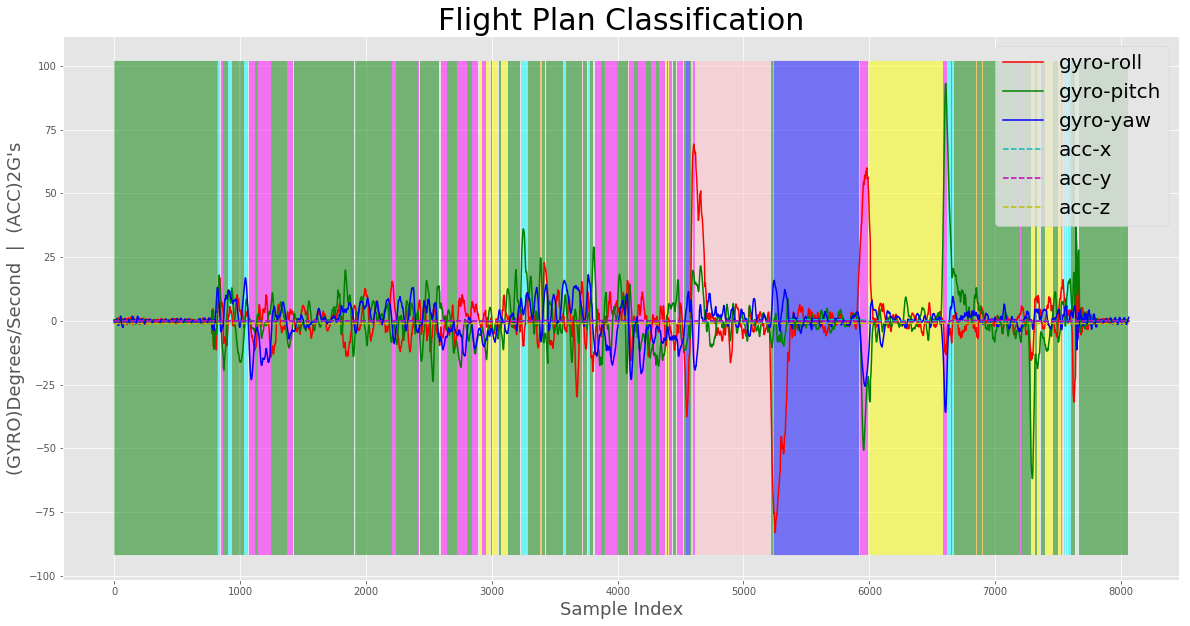

===[STEP 8 - END]===



In [10]:
print('===[STEP 8] - VISUALIZING FLIGHT PLAN - START]===\n')

# split flight data into windows of data samples for each label
matplotlib.rcParams['figure.figsize'] = (20, 10)
matplotlib.rcParams['toolbar'] = 'toolbar2'


def graph_raw_flight_record_data(data_filepath, flightplan_data_filepath):
    with open(data_filepath) as raw_flight_record:
        raw_imu_data = list(reader(raw_flight_record))
        global FLIGHT_RECORD_LENGTH
        FLIGHT_RECORD_LENGTH = len(raw_imu_data)
    
    with open(flightplan_data_filepath) as raw_flightplan_records:
        flight_records = list(reader(raw_flightplan_records))
    plt.style.use('ggplot')
    acc_x = [float(i[0]) for i in raw_imu_data[1::]]
    acc_y = [float(i[1]) for i in raw_imu_data[1::]]
    acc_z = [float(i[2]) for i in raw_imu_data[1::]]
    gyro_roll = [float(i[3]) for i in raw_imu_data[1::]]
    gyro_pitch = [float(i[4]) for i in raw_imu_data[1::]]
    gyro_yaw = [float(i[5]) for i in raw_imu_data[1::]]
    x_t_index = np.arange(len(gyro_roll))
    neutral_fill = plt.fill(np.NaN, np.NaN, 'g', alpha=0.5)
    plt.plot(x_t_index, gyro_roll, 'r', gyro_pitch, 'g', gyro_yaw, 'b', acc_x, 'c--', acc_y, 'm--', acc_z, 'y--')
    
    
    
    
    axes = plt.gca()
    max_plot_value = axes.get_ylim()[1]
    min_plot_value = axes.get_ylim()[0]
    
    y_max = np.full(len(gyro_roll), max_plot_value)
    y_min = np.full(len(gyro_roll), min_plot_value)
    
    for flightPlanChange in flight_records:
        color ='grey'
        if(flightPlanChange[0] == 'neutral'):
            color = 'green'
        elif(flightPlanChange[0] == 'backward'):
            color = 'orange'
        elif(flightPlanChange[0] == 'forward'):
            color = 'yellow'
        elif(flightPlanChange[0] == 'left'):
            color = 'blue'
        elif(flightPlanChange[0] == 'right'):
            color = 'pink'
        elif(flightPlanChange[0] == 'up'):
            color = 'cyan'
        elif(flightPlanChange[0] == 'down'):
            color = 'magenta'
        else:
            color = 'red'
        neutral_fill = plt.fill_between(x_t_index, min_plot_value, max_plot_value, where=(x_t_index>int(flightPlanChange[1]))&(x_t_index<int(flightPlanChange[2])), facecolor=color, alpha=0.5)
    
    plt.legend(['gyro-roll', 'gyro-pitch', 'gyro-yaw', 'acc-x', 'acc-y', 'acc-z'], fontsize=20)
    plt.title('Flight Plan Classification', fontsize=30)
    plt.xlabel('Sample Index', fontsize=18)
    plt.ylabel('(GYRO)Degrees/Second  |  (ACC)2G\'s', fontsize=18)
    plt.show()
    
graph_raw_flight_record_data(jupyter_filepath_group_classification_dataset_latest, './data/group-workspace/' + GROUP_NAME + '/flight-plan-classification-changes.csv')
print('===[STEP 8 - END]===\n')